In [258]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import torch

In [259]:
# Load the metadata
file_path_metadata = '/home/dhalmos/workspace/hw/beng/AD_prediction_blood/silver_seq/silver_seq_metadata.xlsx'
metadata = pd.read_excel(file_path_metadata)

# Load the RNA-seq data from a text file
file_path_rna_seq = '/home/dhalmos/workspace/hw/beng/silver_seq_counts_updown_genes.csv'
rna_seq_data = pd.read_csv(file_path_rna_seq, index_col = 0)  # Adjust sep if necessary

# Transpose RNA-seq data to have samples as rows and genes as columns
rna_seq_data = rna_seq_data.T

# Normalize the RNA-seq data (e.g., using StandardScaler)
scaler = StandardScaler()
rna_seq_data_scaled = scaler.fit_transform(rna_seq_data)

rna_seq_scaled_df = pd.DataFrame(rna_seq_data_scaled , index=rna_seq_data.index)

#rna_seq_data.rename(columns={'index': 'sample_id_alias'}, inplace=True)
rna_seq_scaled_df.index.names = ['sample_id_alias']

# Apply PCA to reduce dimensionality
#pca = PCA(n_components=3)  # Adjust n_components as needed
#rna_seq_pca = pca.fit_transform(rna_seq_data_scaled)

# Convert PCA result to DataFrame and add sample identifiers
#rna_seq_pca_df = pd.DataFrame(rna_seq_pca, index=rna_seq_data.index)
#rna_seq_pca_df.reset_index(inplace=True)
#rna_seq_pca_df.rename(columns={'index': 'sample_id_alias'}, inplace=True)

# Merge metadata with RNA-seq PCA data on 'sample_id_alias'
merged_data = pd.merge(metadata, rna_seq_scaled_df, on='sample_id_alias')

# Display the first few rows of the merged dataframe
# print(merged_data.head())

# Step 1: Label Encoding
label_encoder = LabelEncoder()
merged_data['donor_group'] = label_encoder.fit_transform(merged_data['donor_group'])

# Step 2: Feature Selection
# Use all columns except 'donor_id', 'donor_id_alias', 'sample_id_alias', 'year_sample', and 'donor_group' as features
features = merged_data.drop(columns=['donor_id', 'donor_id_alias', 'sample_id_alias', 'year_sample', 'donor_group', 'donor_status_score', 'braak_stage', 'apoe_dose', 'apoe', 'apoe_carrier'])
print(features.head())
target = merged_data['donor_group']

# Convert categorical features to dummy variables
features = pd.get_dummies(features, drop_first=True)

# Convert boolean features to integers
features = features.applymap(lambda x: int(x) if isinstance(x, bool) else x)

# Ensure all features are numeric
features = features.apply(pd.to_numeric, errors='coerce')

# Fill any remaining NaNs with 0
features = features.fillna(0)

# Verify data types
print(features.dtypes)

# Step 3: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

        0         1         2         3         4         5         6    \
0 -0.706798 -0.327759 -0.004348 -0.811933  0.295555 -0.529359 -0.558645   
1 -1.163437 -0.850456  1.245664 -0.811933 -0.732013 -0.846836 -1.091791   
2 -0.184925 -0.966611 -0.254350 -0.270644 -0.573926 -0.370620 -0.625288   
3  0.663120 -0.385836  0.495657  0.270644  0.058424  0.978658  1.374011   
4  0.663120  1.182255 -0.754355  0.000000  1.085991  0.502442  0.174432   

        7         8         9    ...       269       270       271       272  \
0 -0.190362 -0.939606 -0.753416  ... -0.366598 -0.146447 -0.622442  0.106965   
1 -0.479680 -0.939606 -0.213585  ...  1.214354 -1.265065  1.116906 -0.756265   
2  1.352663 -0.826814 -0.618459  ... -0.103106 -0.426102  1.652090  0.862292   
3  0.581151 -1.052398 -0.213585  ... -0.103106 -0.177520 -1.157626 -0.864168   
4 -0.286802  0.639481  0.326246  ... -0.498344 -0.084302  0.447926 -0.540457   

        273       274       275       276       277       278  
0 -0

/tmp/ipykernel_3548675/2367624201.py:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: int(x) if isinstance(x, bool) else x)


In [260]:
# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


In [261]:
merged_data

,donor_id,donor_id_alias,sample_id_alias,year_sample,donor_status_score,donor_group,braak_stage,apoe,apoe_carrier,apoe_dose,...,269,270,271,272,273,274,275,276,277,278
0,8140,AD_1,AD_1_02_1,2002,A,0,5,34,apoe4,apoe4,...,-0.366598,-0.146447,-0.622442,0.106965,-0.552757,-1.031258,-0.493454,-0.179370,0.139324,-0.670935
1,8140,AD_1,AD_1_04_1,2004,A,0,5,34,apoe4,apoe4,...,1.214354,-1.265065,1.116906,-0.756265,-0.795071,-0.866084,-0.140987,0.244484,-0.506261,-0.551311
2,8140,AD_1,AD_1_08_1,2008,A,0,5,34,apoe4,apoe4,...,-0.103106,-0.426102,1.652090,0.862292,0.497271,-1.196432,-0.493454,0.527053,1.019667,0.345869
3,8140,AD_1,AD_1_09_1,2009,A,0,5,34,apoe4,apoe4,...,-0.103106,-0.177520,-1.157626,-0.864168,-0.229672,0.620478,-0.422960,-0.673866,0.315393,-0.132627
4,8140,AD_1,AD_1_11_1,2011,A,0,5,34,apoe4,apoe4,...,-0.498344,-0.084302,0.447926,-0.540457,-0.552757,-0.370563,-0.634441,-0.038085,0.550151,-0.132627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,647,N_9,N_9_00_1,2000,N--,1,2,23,no_apoe4,no_apoe4,...,1.609592,0.754662,-0.622442,0.214869,-0.795071,-0.535737,-0.563947,-0.179370,-0.682330,2.618726
111,647,N_9,N_9_03_1,2003,N-,1,2,23,no_apoe4,no_apoe4,...,-0.498344,-0.457174,0.046538,-0.432553,-0.633529,-0.370563,-0.211480,1.304118,-0.095434,0.884178
112,647,N_9,N_9_06_1,2006,N,1,2,23,no_apoe4,no_apoe4,...,-0.103106,-0.892192,-0.488646,0.322773,-0.471986,0.124957,-1.268881,-0.815150,-1.034467,-0.910183
113,647,N_9,N_9_08_1,2008,N,1,2,23,no_apoe4,no_apoe4,...,-0.893582,-0.395029,0.849314,-0.864168,-0.714300,-0.535737,-1.198388,0.032557,-0.330192,-1.149431


In [262]:
# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
num_classes = 2  # Binary classification: AD or N

model = SimpleNN(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Train the model
num_epochs = 1000

for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Move data to GPU
        data, targets = data.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluate the model on the test set after each epoch
    model.eval()
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for data, targets in test_loader:
            # Move data to GPU
            data, targets = data.to(device), targets.to(device)
            
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate F1 score
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, F1 Score: {f1:.4f}')

# Evaluate the model and calculate AUC
model.eval()
all_targets = []
all_predictions = []
all_probabilities = []

with torch.no_grad():
    correct = 0
    total = 0
    for data, targets in test_loader:
        # Move data to GPU
        data, targets = data.to(device), targets.to(device)
        
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

accuracy = 100 * correct / total

# Calculate AUC
auc = roc_auc_score(all_targets, all_probabilities)

print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
print(f'AUC of the model on the test set: {auc:.4f}')

Epoch [1/1000], Loss: 0.6534, F1 Score: 0.5708
Epoch [2/1000], Loss: 0.6846, F1 Score: 0.5708
Epoch [3/1000], Loss: 0.6256, F1 Score: 0.5708
Epoch [4/1000], Loss: 0.6794, F1 Score: 0.5708
Epoch [5/1000], Loss: 0.6633, F1 Score: 0.5708
Epoch [6/1000], Loss: 0.6962, F1 Score: 0.5708
Epoch [7/1000], Loss: 0.6408, F1 Score: 0.5708
Epoch [8/1000], Loss: 0.7131, F1 Score: 0.5708
Epoch [9/1000], Loss: 0.6752, F1 Score: 0.5708
Epoch [10/1000], Loss: 0.6834, F1 Score: 0.5708
Epoch [11/1000], Loss: 0.6872, F1 Score: 0.5708
Epoch [12/1000], Loss: 0.6154, F1 Score: 0.5708
Epoch [13/1000], Loss: 0.6399, F1 Score: 0.5708
Epoch [14/1000], Loss: 0.6376, F1 Score: 0.5708
Epoch [15/1000], Loss: 0.6458, F1 Score: 0.5708
Epoch [16/1000], Loss: 0.6761, F1 Score: 0.5708
Epoch [17/1000], Loss: 0.6461, F1 Score: 0.5708
Epoch [18/1000], Loss: 0.6983, F1 Score: 0.5708
Epoch [19/1000], Loss: 0.6636, F1 Score: 0.5708
Epoch [20/1000], Loss: 0.6238, F1 Score: 0.5708
Epoch [21/1000], Loss: 0.6225, F1 Score: 0.5708
E

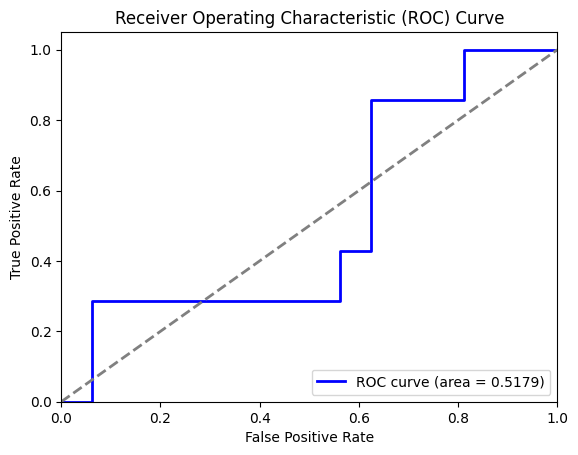

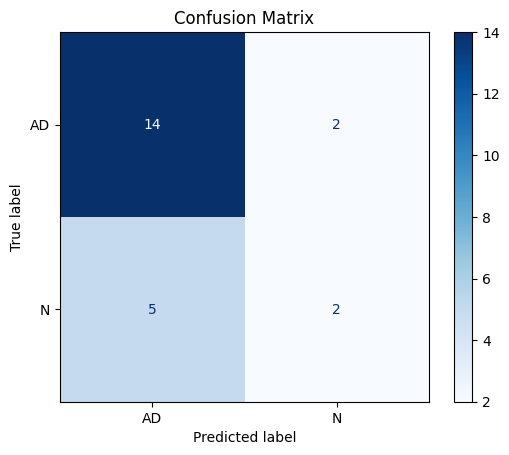

In [263]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(all_targets, all_probabilities)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [264]:
toden_path = "/home/dhalmos/workspace/hw/beng/toden_counts_updown_genes.csv"
toden_data = pd.read_csv(toden_path, index_col = 0)

In [265]:
print(toden_data)

                 SRR10192321  SRR10192320  SRR10192319  SRR10192318  \
index                                                                 
ENSG00000078369         3579         4036         3483         4901   
ENSG00000130939          920          753         1037          384   
ENSG00000162545           67           22           32            2   
ENSG00000173372          202          333          145          138   
ENSG00000004455          246          293          316          251   
...                      ...          ...          ...          ...   
ENSG00000182858            5           53           37           81   
ENSG00000142192         1276         3400         3104         4840   
ENSG00000156273         1298         2149         1889          835   
ENSG00000159082          232          247          239           95   
ENSG00000197381          679          652          609          770   

                 SRR10192317  SRR10192316  SRR10192315  SRR10192314  \
index

In [266]:
toden_metadata_path = "/home/dhalmos/workspace/hw/beng/AD_prediction_blood/toden/toden_metadata.xlsx"
toden_metadata = pd.read_excel(toden_metadata_path)

In [267]:
toden_data = toden_data.T

# Normalize the RNA-seq data (e.g., using StandardScaler)
scaler = StandardScaler()
toden_data_scaled = scaler.fit_transform(toden_data)

toden_scaled_df = pd.DataFrame(toden_data_scaled , index=toden_data.index)

#rna_seq_data.rename(columns={'index': 'sample_id_alias'}, inplace=True)
toden_scaled_df.index.names = ['Run']
toden_merged_data = pd.merge(toden_metadata, toden_scaled_df, on='Run')

In [268]:
print(toden_merged_data)

             Run  Tissue   Age  PatientID         Ethnicity  Gender  \
0    SRR10192321  Plasma  75.0        434               NaN  Female   
1    SRR10192320  Plasma  74.0        435               NaN  Female   
2    SRR10192319  Plasma  73.0        438               NaN  Female   
3    SRR10192318  Plasma  68.0        447               NaN    Male   
4    SRR10192317  Plasma  68.0        447               NaN    Male   
..           ...     ...   ...        ...               ...     ...   
329  SRR10192327  Plasma  87.0       2657         Caucasian  Female   
330  SRR10192326  Plasma  86.0       2658  African American    Male   
331  SRR10192325  Plasma  65.0       2659          Hispanic  Female   
332  SRR10192324  Plasma  66.0       2660          Hispanic    Male   
333  SRR10192322  Plasma  65.0       2662               NaN    Male   

                                    Center Disease  MMSE  CDR  ...       269  \
0    University of Washington at St. Louis     NCI  30.0  0.0  ... 

In [269]:
print(y_train)

31     0
67     0
93     1
109    1
22     0
      ..
106    1
14     0
92     1
51     0
102    1
Name: donor_group, Length: 92, dtype: int64


In [270]:
print(list(toden_merged_data.columns))

['Run', 'Tissue', 'Age', 'PatientID', 'Ethnicity', 'Gender', 'Center', 'Disease', 'MMSE', 'CDR', 'Apoe.status', 'apoe_carrier', 'apoe_dose', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,

In [271]:
toden_target = toden_merged_data['Disease']
toden_target = toden_target.apply(lambda x: 1 if 'AD' in x else 0)

# Convert categorical features to dummy variables
toden_features = toden_merged_data[[i for i in range(279)]]
toden_features = pd.get_dummies(toden_features, drop_first=True)

# Convert boolean features to integers
toden_features = toden_features.applymap(lambda x: int(x) if isinstance(x, bool) else x)

# Ensure all features are numeric
toden_features = toden_features.apply(pd.to_numeric, errors='coerce')

# Fill any remaining NaNs with 0
toden_features = toden_features.fillna(0)

/tmp/ipykernel_3548675/3304613840.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  toden_features = toden_features.applymap(lambda x: int(x) if isinstance(x, bool) else x)


In [272]:
print(toden_features)

          0         1         2         3         4         5         6    \
0    0.048380  0.640367  3.445125 -0.057064  0.413194 -1.083878  0.164791   
1    0.231488  0.270531  0.687043  0.630753  0.748369  0.927999  0.630072   
2    0.009915  0.899474  1.299950 -0.356343  0.912391  0.314622  1.236347   
3    0.578071 -0.546652 -0.538771 -0.393096  0.448851  0.020201 -0.671104   
4   -0.387554 -0.024009  0.012845 -0.314339 -0.292814  0.609043 -0.201794   
..        ...       ...       ...       ...       ...       ...       ...   
329 -1.018616 -0.905415 -0.600062 -0.655622 -0.906114 -0.764922 -0.767785   
330 -0.738144 -0.843407 -0.661352 -0.860392 -1.005953 -0.789457 -1.398231   
331 -1.186098 -1.235389 -0.354899 -1.070412 -1.155713 -1.034808 -1.247166   
332 -1.085529 -1.078153 -0.661352 -1.107165 -1.248421 -0.396895 -1.388160   
333 -1.045461 -0.821261 -0.661352 -1.091414 -1.091530 -1.034808 -1.071930   

          7         8         9    ...       269       270       271  \
0  

In [273]:
eval_x_tensor = torch.tensor(toden_features.values, dtype=torch.float32)
eval_y_tensor = torch.tensor(toden_target.values, dtype=torch.float32)

In [274]:
eval_dataset = TensorDataset(eval_x_tensor, eval_y_tensor)
eval_loader = DataLoader(eval_dataset, batch_size=16)

In [275]:
model.eval()
all_targets = []
all_predictions = []
all_probabilities = []

with torch.no_grad():
    correct = 0
    total = 0
    for data, targets in eval_loader:
        # Move data to GPU
        data, targets = data.to(device), targets.to(device)
        
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

accuracy = 100 * correct / total

# Calculate AUC
auc = roc_auc_score(all_targets, all_probabilities)

print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
print(f'AUC of the model on the test set: {auc:.4f}')

Accuracy of the model on the test set: 54.49%
AUC of the model on the test set: 0.6420
